In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from synthesizer import Synthesizer
from generator import Generator
from algorithm import Algorithm

warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 80
sns.set()

#### Генерируем данные

In [2]:
# Cоздание синтезатора, генерирующего workers_num комбинаций рандомных параметров, для каждой из которых создает по генератору временного ряда.
# Параметры для генератора включают: ar1, ma1, ma2 - коэффициенты для ARIMA(1, 0, 2); trend_coef - коэффициент линейного тренда 
# Плюс добавляется нормальный шум N(0,1) и опционально сезонность (но я её отключил пока)
synt = Synthesizer(workers_num=4)

# Создание генератора данных, способного склеивать разнородные временные ряды в один путем подсчета средних на концах
# В данном случае источник рядов - наш синтезатор
gen = Generator(synt)

# Получение итогового временного ряда путем получения от синтезатора pieces_num временных рядов 
# произвольного размера из [lower_bound, upper_bound) и их последующей склейки
gen.generate(pieces_num=8, lower_bound=40, upper_bound=80)

#### Выглядит это так:

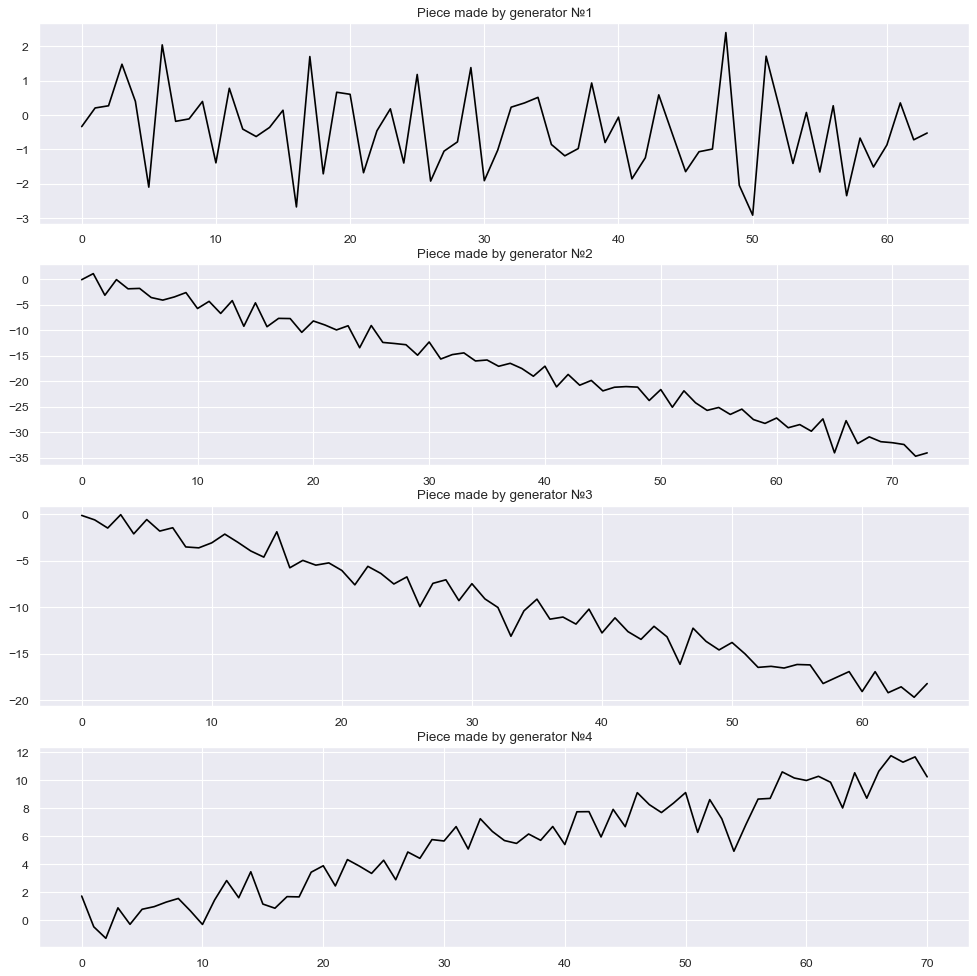

In [3]:
gen.show_time_series()

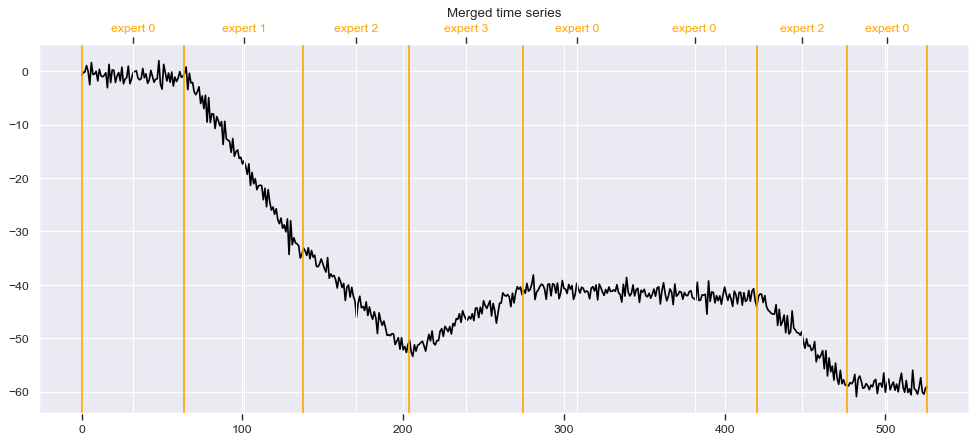

In [4]:
gen.draw_binded()

#### Запуск алгоритма

In [5]:
# Cоздание объекта GMMP алгоритма, работающего total_time итераций, добавляющего экспертов с периодичностью period
# Здесь gen.total_time - сколько получил генератор
# Каждый эксперт представляет из себя ARIMA(1, 0, 2) модель, которая при инициализации тренируется на последних train_window точках
algo = Algorithm(gen, total_time=gen.total_time, period=10, train_window=40)

# Запуск 
algo.run()

Возникает вопрос, как дообучать модели. \
С одной стороны, вся идея в том, чтобы не потерять модель, которая помнила правильные параметры. \
С другой, к следующему моменту когда заработает её родной генератор, тренд уже скакнет.  \
Тут я просто дообучаю на каждой новой точке.

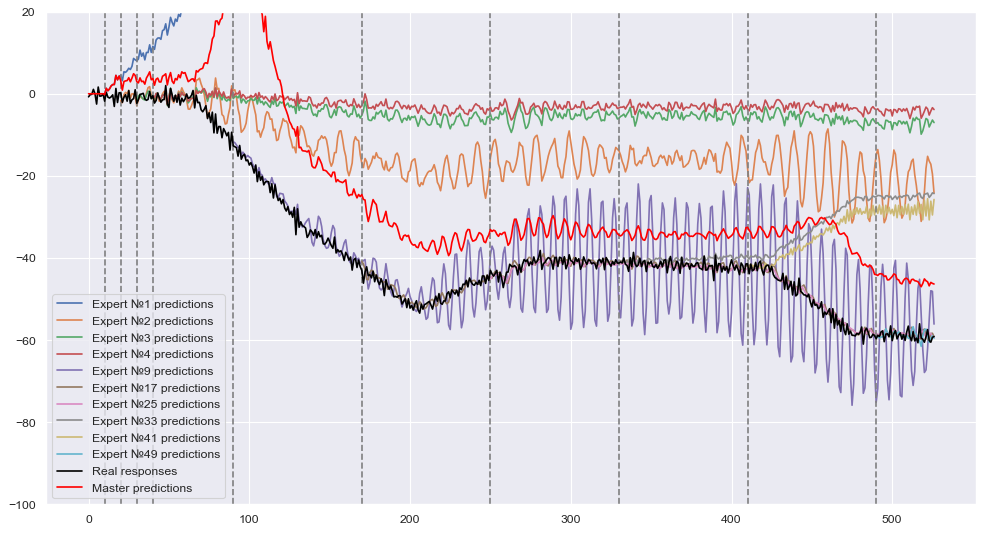

In [6]:
plt.figure(figsize=(15, 8))
for i, p in enumerate(algo.init_points):
    # plt.axvline(p, color='grey', linestyle='--')
    if i < 4 or i % 8 == 0:
        plt.axvline(p, color='grey', linestyle='--')
        plt.plot(np.arange(algo.total_time)[algo.init_points[i]:], algo.experts_predictions_all.T[i][algo.init_points[i]:], label=f"Expert №{i+1} predictions")
plt.plot(np.arange(algo.total_time), algo.responses, label="Real responses", color='black')
plt.plot(np.arange(algo.total_time), algo.master_predictions_all, label="Master predictions", color='red')
plt.ylim(-100, 20)
plt.legend()
plt.show()